# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

In [2]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min=40

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

## Figure 2a (number of beads in condensates)

In [4]:
def plot_confidence_int(ax, time_arr, mean, std_dev, num_runs=12, color='b', ci=.95, label='Mean'):
    degrees_freedom = num_runs - 1
    confidence_interval = stats.t.ppf((1 + ci) / 2., degrees_freedom) * std_dev / np.sqrt(num_runs)

    _ = ax.plot(time_arr, mean, label=label, color=color)
    _ = ax.fill_between(time_arr, mean - confidence_interval, mean + confidence_interval, color=color, alpha=.1)

In [20]:
slice_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations"
data_path_dict = {'Baseline': slice_path / "Ke30_Pin5.0um/", 
                  r'$L_{sep} = 3~\mu {\rm m}$' :slice_path / "Ke30_Pin3.0um/",
                  r'$L_{sep} = 9~\mu {\rm m}$' : slice_path / "Ke30_Pin9.0um/",
                  r'$K_e = 3~\mu {\rm M}^{-1}$' : slice_path / "Ke3_Pin5.0um/",
                  r'$K_e = 100~\mu {\rm M}^{-1}$' : slice_path / "Ke100_Pin5.0um/",
                  }
# [x] Baseline (2x Ke 30, pin 5um)
# [x] short_separation (2x Ke 30, pin 3um)
# [x] large separation (2x Ke 30 pin 9um
# [x] low Ke (2x Ke 3, pin 5um)
# [x] high Ke (2x Ke 100, pin 5um)

part_min=40

try:
    fig, axarr = plt.subplots(1, 1, figsize=(10, 6))
    avg_num_clust_beads_stats = {}
    for label, data_path, color in zip(data_path_dict.keys(), data_path_dict.values(), mcolors.XKCD_COLORS.keys()):
        print(data_path)
        sd_h5_file_lst = [h5p for h5p in data_path.glob('s*/analysis/raw_data.h5')]
        min_run_length = min([len(h5py.File(h5p, 'r')['time'][ss_ind:end_ind]) for h5p in sd_h5_file_lst])
        with h5py.File(sd_h5_file_lst[0], 'r') as h5d:
            nbeads = h5d['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
            time_arr = h5d['time'][0:min_run_length]


        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / 'cluster_analysis.h5'
            with h5py.File(h5_clust_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                # time_arr = h5_data['time'][...]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # num_clusters_list = np.zeros(len(clusters))
            # avg_num_cluster_beads_list = np.zeros(len(clusters))
            assert len(clusters) >= min_run_length

            bead_ind_arr = np.zeros((nbeads, min_run_length))
            one_mask = np.ones(nbeads)
            for c, clust_grp in enumerate(clusters):
                if c >= min_run_length:
                    break
                # Secondary thresholding
                clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
                # num_clusters_list[c] += [len(clust_grp)]
                num_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)
                    bead_ind_arr[clust.part_ids, c] += one_mask[clust.part_ids]

                avg_num_clust_beads_arr[ih, c] += num_beads

        mean = avg_num_clust_beads_arr.mean(axis=0)
        std_dev = avg_num_clust_beads_arr.std(axis=0)
        avg_num_clust_beads_stats[label] = [mean, std_dev, len(sd_h5_file_lst)]
        plot_confidence_int(axarr, time_arr, mean, std_dev, color=color, label=label)

    _ = axarr.set_ylabel('Number of beads in clusters')
    _ = axarr.set_xlabel('Time (sec)')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        

except:
    raise
finally:
    pass
    # for h5d in sd_h5_data_lst:
    #     h5d.close()

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um


In [9]:
# # Save avg_num_clust_beads_stats as an hdf5 file
# with h5py.File('Figure2/fig2a_avg_num_clust_beads_stats.h5', 'w') as h5d:
#     for label, data in avg_num_clust_beads_stats.items():
#         dset = h5d.create_dataset(label, data=data[:2])
#         dset.attrs['num_runs'] = data[2]
#     _ = h5d.create_dataset('time', data=time_arr)



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


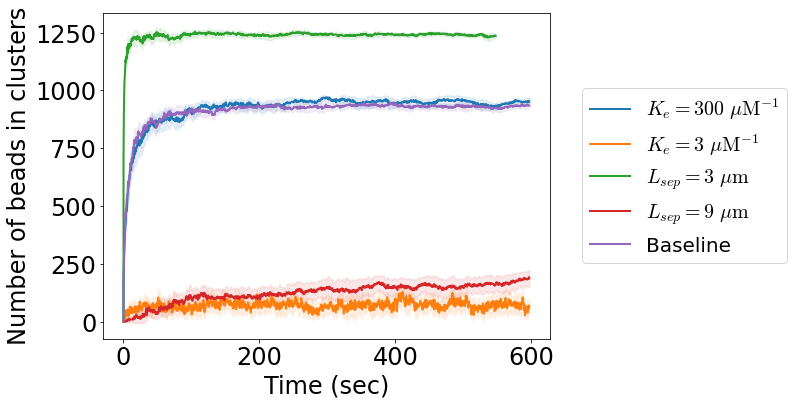

In [5]:
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))

with h5py.File('Figure2/fig2a_avg_num_clust_beads_stats.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    # iterate over the datasets
    for label, color in zip(h5d.keys(), plt.cm.tab10.colors):
        if label == 'time':
            continue
        h5_data = h5d[label]
        mean = h5_data[0,:]

        min_length = min(mean.size, time_arr.size)
        std_dev = h5_data[1,:]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length], mean[:min_length], std_dev[:min_length], num_runs, color=color, label=label)

    _ = axarr.set_ylabel('Number of beads in clusters')
    _ = axarr.set_xlabel('Time (sec)')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        


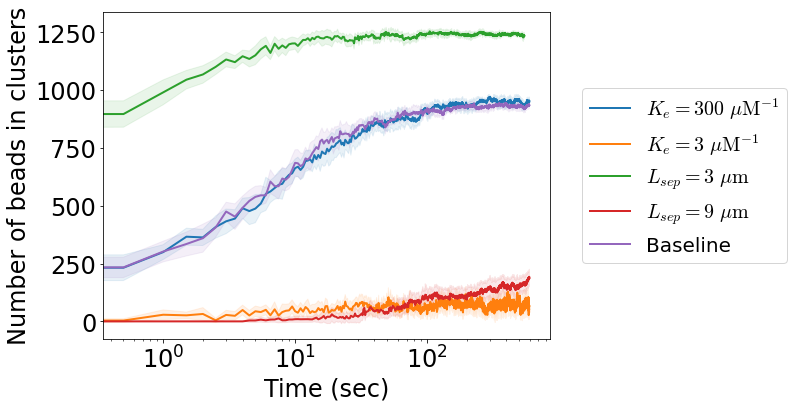

In [20]:
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))

with h5py.File('Figure2/fig2a_avg_num_clust_beads_stats.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    # iterate over the datasets
    for label, color in zip(h5d.keys(), plt.cm.tab10.colors):
        if label == 'time':
            continue
        h5_data = h5d[label]
        mean = h5_data[0,:]

        min_length = min(mean.size, time_arr.size)
        std_dev = h5_data[1,:]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length], mean[:min_length], std_dev[:min_length], num_runs, color=color, label=label)
        axarr.set_xscale('log')

    _ = axarr.set_ylabel('Number of beads in clusters')
    _ = axarr.set_xlabel('Time (sec)')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        


## Figure 2b (Condensate state diagram)

In [21]:
slice_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations"

pin_ke_data_dict = {}

def parse_params(param_dir):
    data_path = next(param_dir.glob('s*')) / 'analysis/raw_data.h5'
    with h5py.File(data_path, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        prot_params = yaml.safe_load(h5_data.attrs['ProteinConfig'])

    return run_params['pinDist'], prot_params['proteins'][0]['Ke'][1]

for param_dir in slice_path.glob('*') :
    print(param_dir)
    try:
        pin_dist, Ke = parse_params(param_dir)
        if pin_dist not in pin_ke_data_dict:
            pin_ke_data_dict[pin_dist] = {}

        # pin_ke_data_dict[pin_dist][Ke]= [pin_dist, Ke] 

        sd_h5_file_lst = [h5p for h5p in param_dir.glob('s*/analysis/raw_data.h5')]
        
        num_runs += [len(sd_h5_file_lst)]
        min_run_length = min([len(h5py.File(h5p, 'r')['time']) for h5p in sd_h5_file_lst])
        with h5py.File(sd_h5_file_lst[0], 'r') as h5d:
            time_arr = h5d['time'][ss_ind:end_ind]
            nbeads = h5d['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]

        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))

        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / 'cluster_analysis.h5'
            with h5py.File(h5_clust_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # assert len(clusters) == time_arr.size

            for c, clust_grp in enumerate(clusters):
                if c >= min_run_length:
                    break
                # Secondary thresholding
                clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]

                
                num_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads

        num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
        num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
        num_clust_mean = avg_num_clust_arr.mean(axis=0)
        num_clust_std_dev = avg_num_clust_arr.std(axis=0)
        pin_ke_data_dict[pin_dist][Ke] = [num_bead_mean, num_bead_std_dev , num_clust_mean, num_clust_std_dev, num_runs]

    except:
        print("Error occured")
        pass



/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke10_Pin11.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke1_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke10_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke1_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/

In [22]:
# Store pin_ke_data_dict as an hdf5 file
# with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'w') as h5d:
#     _ = h5d.create_dataset('time', data=time_arr)
#     for pin_dist, ke_data in pin_ke_data_dict.items():
#         for ke, data in ke_data.items():
#             dset = h5d.create_dataset(f'Pin{pin_dist:.1f}um_Ke{ke:.3g}', data=np.vstack(data[:-1]).T)
#             dset.attrs['pin_dist'] = pin_dist
#             dset.attrs['Ke'] = ke
#             dset.attrs['num_runs'] = data[-1]
            

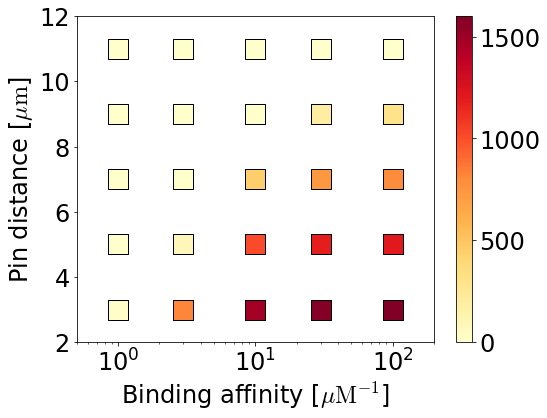

In [32]:
with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    data_arr = np.zeros((len(h5d.keys()), 4))
    labels = []
    time_arr = h5d['time'][...]
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            data_arr[i,...]  = [h5_data.attrs['pin_dist'], 
                                h5_data.attrs['Ke'], 
                                h5_data[time_arr.size//2:, 0].mean(),
                                h5_data[time_arr.size//2:, 1].mean()] 

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
_ = axarr.set_xscale('log')
_ = axarr.scatter(data_arr[:, 1], data_arr[:, 0], c=data_arr[:, 2], cmap='YlOrRd', s=400, marker='s', edgecolors='k', linewidths=1)

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1600), cmap='YlOrRd'), ax=axarr)
_ = axarr.set_xlim(.5, 200)
_ = axarr.set_ylim(2,12)
_ = axarr.set_ylabel(r'Pin distance [$\mu {\rm m}$]')
_ = axarr.set_xlabel(r'Binding affinity [$\mu {\rm M}^{-1}$]')

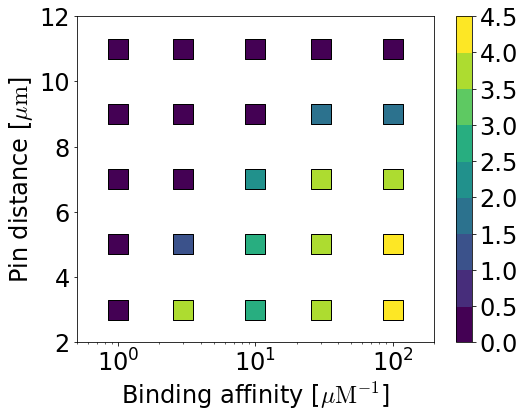

In [35]:
with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    data_arr = np.zeros((len(h5d.keys()), 4))
    labels = []
    time_arr = h5d['time'][...]
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            data_arr[i,...]  = [h5_data.attrs['pin_dist'], 
                                h5_data.attrs['Ke'], 
                                h5_data[time_arr.size//2:, 2].mean(),
                                h5_data[time_arr.size//2:, 3].mean()] 



fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
_ = axarr.set_xscale('log')

# Define the number of color steps you want
n_bins = 9 # for example

# Create a colormap with the desired number of color steps
cmap = plt.get_cmap('viridis', n_bins)

# Create a norm with boundaries at the desired locations
boundaries = np.linspace(0, int(np.max(data_arr[:,2]))+.5, n_bins+1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Create the scatter plot
sc = axarr.scatter(data_arr[:, 1], data_arr[:, 0], c=data_arr[:, 2], cmap=cmap, norm=norm, s=400, marker='s', edgecolors='k', linewidths=1)

# Create a colorbar
cb1 = fig.colorbar(sc, ax=axarr, ticks=boundaries)

_ = axarr.set_xlim(.5, 200)
_ = axarr.set_ylim(2,12)
_ = axarr.set_ylabel(r'Pin distance [$\mu {\rm m}$]')
_ = axarr.set_xlabel(r'Binding affinity [$\mu {\rm M}^{-1}$]')

## Figure 2c (Comparison with experiments)

In [11]:
# Functions
def free_energy_droplet(Ld, mu, alpha, gamma):
    return -mu*alpha*Ld + gamma * 4. * np.pi * np.power(3.*alpha*Ld/(4*np.pi), 2./3.)

def free_energy_polymer(Ld, Ltot, Lsep, kappa):
    eps = Ltot - Ld
    return .25* kappa* ((eps /(1.-(Lsep/eps))) - Lsep + 2.*((Lsep*Lsep)/eps) - eps)

def tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return free_energy_droplet(Ld, mu, alpha, gamma) + free_energy_polymer(Ld, Ltot, Lsep, kappa)

def free_energy_deriv(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return -mu*alpha + (1./12.) * (8.*np.power(6.*alpha, 2./3.)*gamma*np.power(np.pi/Ld, 1./3.) + 3.*kappa*(Lsep**2)*(2./np.power(Ld-Ltot, 2.) + 1./np.power(Lsep + Ld - Ltot, 2.)))

def length_prob_unnorm(Ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=1./.0041):
    return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
    # return tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)

def partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=1./.0041):
    return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))

/tmp/ipykernel_2620800/1772400338.py:20: RuntimeWarning: overflow encountered in exp
  return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))
/tmp/ipykernel_2620800/1772400338.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
/tmp/ipykernel_2620800/2359384887.py:14: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')
/tmp/ipykernel_2620800/1772400338.py:20: RuntimeWarning: overflow encountered in exp
  return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))
/tmp/ipykernel_2620800/1772400338.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
/tmp/ipykernel_2620800/2359384887.py:19: Runtim

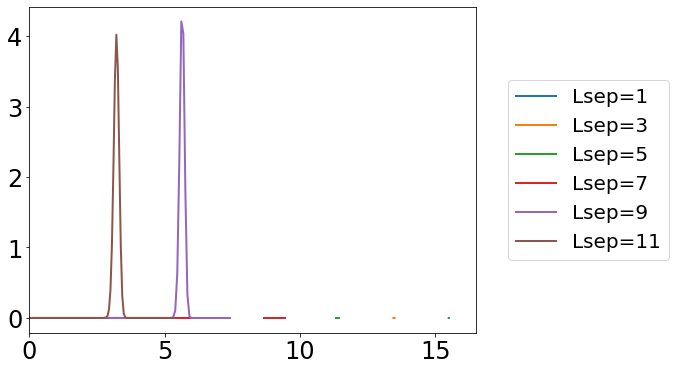

In [12]:
# Parameters (from Renger et al.)
mu = 11. # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16.5 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))

Lsep = 1 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 3 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 5 
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 7 
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 9 
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 11
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')
_ = axarr.set_xlim(0, 16.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))



# length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa),


7.41

/tmp/ipykernel_2620800/1772400338.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return -mu*alpha + (1./12.) * (8.*np.power(6.*alpha, 2./3.)*gamma*np.power(np.pi/Ld, 1./3.) + 3.*kappa*(Lsep**2)*(2./np.power(Ld-Ltot, 2.) + 1./np.power(Lsep + Ld - Ltot, 2.)))


5.647185307639498


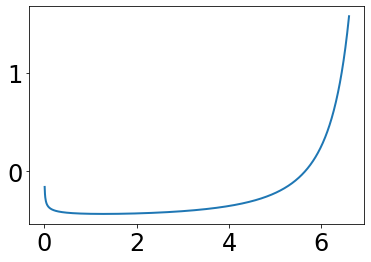

In [13]:
from scipy.optimize import root_scalar
Lsep = 9
Ltot-(Lsep*1.01)
ld = np.linspace(0, Ltot-(Lsep*1.1), 1000)
plt.plot(ld, free_energy_deriv(ld, Ltot, Lsep, mu, alpha, gamma, kappa))
# # Find a root of the function
result = root_scalar(free_energy_deriv, method='brentq', bracket=[0.1, Ltot-(Lsep*1.1)], args=(Ltot, Lsep, mu, alpha, gamma, kappa))

# # Print the root
print(result.root)

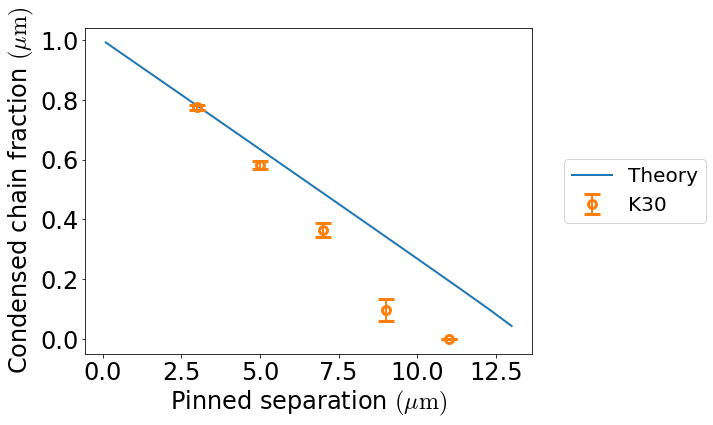

In [27]:
from scipy.optimize import root_scalar

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# Get theoretical results
lsep_arr = np.linspace(0.1, 13, 20)
ld_max_prob = np.zeros(lsep_arr.size) 
for i, lsep in enumerate(lsep_arr):
    result = root_scalar(free_energy_deriv, method='brentq', bracket=[0.1, Ltot-(lsep*1.1)], args=(Ltot, lsep, mu, alpha, gamma, kappa))
    ld_max_prob[i] = result.root
_ = axarr.plot(lsep_arr, ld_max_prob/16.5, label='Theory')
_ = axarr.set_xlabel(r'Pinned separation $(\mu {\rm m})$')
_ = axarr.set_ylabel(r'Condensed chain fraction $(\mu {\rm m})$')

with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    labels = []
    time_arr = h5d['time'][...]
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=8, markerfacecolor='none', capsize=8, label='K30')

    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 100:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    # _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markersize=6, markerfacecolor='none', capsize=6, label='Ke100')

_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))


# # Print the root

2.84702446440215e-68


/tmp/ipykernel_2616279/1772400338.py:20: RuntimeWarning: overflow encountered in exp
  return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))
/tmp/ipykernel_2616279/1772400338.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
/tmp/ipykernel_2616279/804397414.py:14: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')


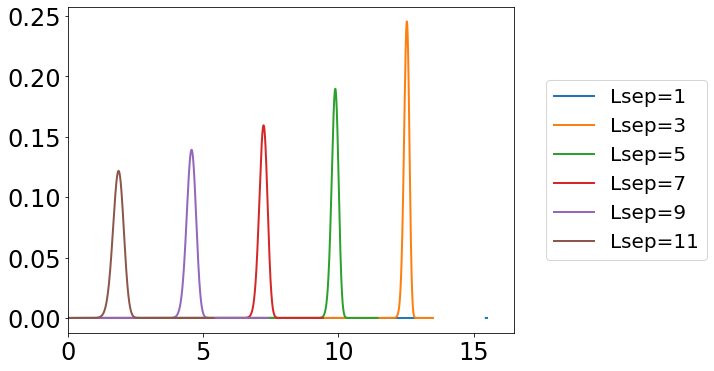

In [13]:
# Parameters (from Renger et al.)
mu = 2.6 # Free energy per volume pN/um
alpha = .09 # Condensate packing factor um^2 
gamma = .04 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16.5 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))

Lsep = 1 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 3 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 5 
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 7 
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 9 
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 11
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]* Ltot
print(Z)
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')
_ = axarr.set_xlim(0, 16.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))



# length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa),


# Old

In [ ]:
slice_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations"

pin_ke_data_dict = {}

def parse_params(param_dir):
    data_path = next(param_dir.glob('s*')) / 'analysis/raw_data.h5'
    with h5py.File(data_path, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        prot_params = yaml.safe_load(h5_data.attrs['ProteinConfig'])

    return run_params['pinDist'], prot_params['proteins'][0]['Ke'][1]

for param_dir in slice_path.glob('*') :
    print(param_dir)
    try:
        pin_dist, Ke = parse_params(param_dir)
        if pin_dist not in pin_ke_data_dict:
            pin_ke_data_dict[pin_dist] = {}

        # pin_ke_data_dict[pin_dist][Ke]= [pin_dist, Ke] 

        sd_h5_file_lst = [h5p for h5p in param_dir.glob('s*/analysis/raw_data.h5')]
        
        num_runs += [len(sd_h5_file_lst)]
        with h5py.File(sd_h5_file_lst[0], 'r') as h5d:
            time_arr = h5d['time'][ss_ind:end_ind]
            nbeads = h5d['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]

        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), time_arr.size))
        avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), time_arr.size))

        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / 'cluster_analysis.h5'
            with h5py.File(h5_clust_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            assert len(clusters) == time_arr.size

            for c, clust_grp in enumerate(clusters):
                # Secondary thresholding
                clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]

                
                num_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads

        num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
        num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
        num_clust_mean = avg_num_clust_arr.mean(axis=0)
        num_clust_std_dev = avg_num_clust_arr.std(axis=0)
        pin_ke_data_dict[pin_dist][Ke] = [num_bead_mean, num_bead_std_dev , num_clust_mean, num_clust_std_dev, num_runs]

    except:
        print("Error occured")
        pass



/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke300_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke10_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke3_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke30_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke300_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynC

In [ ]:
# Store pin_ke_data_dict as an hdf5 file
with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'w') as h5d:
    _ = h5d.create_dataset('time', data=time_arr)
    for pin_dist, ke_data in pin_ke_data_dict.items():
        for ke, data in ke_data.items():
            dset = h5d.create_dataset(f'Pin{pin_dist:.1f}um_Ke{ke:.3g}', data=np.vstack(data[:-1]).T)
            dset.attrs['pin_dist'] = pin_dist
            dset.attrs['Ke'] = ke
            dset.attrs['num_runs'] = data[-1]
            

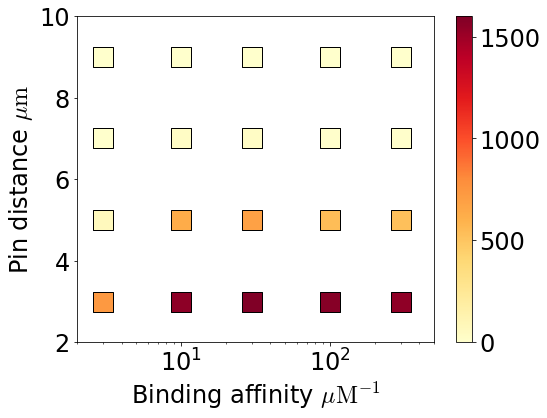

In [ ]:
with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    data_arr = np.zeros((len(h5d.keys()), 4))
    labels = []
    time_arr = h5d['time'][...]
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            data_arr[i,...]  = [h5_data.attrs['pin_dist'], 
                                h5_data.attrs['Ke'], 
                                h5_data[time_arr.size//2:, 0].mean(),
                                h5_data[time_arr.size//2:, 1].mean()] 

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
_ = axarr.set_xscale('log')
_ = axarr.scatter(data_arr[:, 1], data_arr[:, 0], c=data_arr[:, 2], cmap='YlOrRd', s=400, marker='s', edgecolors='k', linewidths=1)

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1600), cmap='YlOrRd'), ax=axarr)
_ = axarr.set_xlim(2, 500)
_ = axarr.set_ylim(2,10)
_ = axarr.set_ylabel(r'Pin distance $\mu {\rm m}$')
_ = axarr.set_xlabel(r'Binding affinity $\mu {\rm M}^{-1}$')

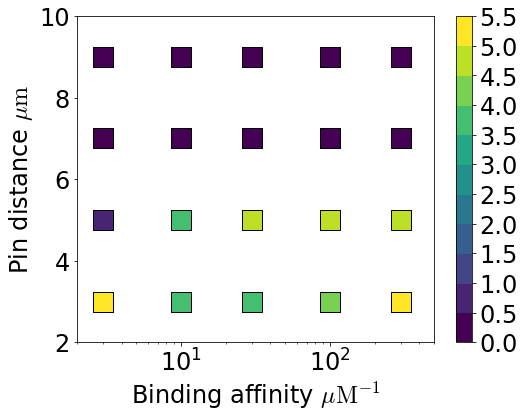

In [ ]:
with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    data_arr = np.zeros((len(h5d.keys()), 4))
    labels = []
    time_arr = h5d['time'][...]
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            data_arr[i,...]  = [h5_data.attrs['pin_dist'], 
                                h5_data.attrs['Ke'], 
                                h5_data[time_arr.size//2:, 2].mean(),
                                h5_data[time_arr.size//2:, 3].mean()] 



fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
_ = axarr.set_xscale('log')

# Define the number of color steps you want
n_bins = 11 # for example

# Create a colormap with the desired number of color steps
cmap = plt.get_cmap('viridis', n_bins)

# Create a norm with boundaries at the desired locations
boundaries = np.linspace(0, int(np.max(data_arr[:,2]))+.5, n_bins+1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Create the scatter plot
sc = axarr.scatter(data_arr[:, 1], data_arr[:, 0], c=data_arr[:, 2], cmap=cmap, norm=norm, s=400, marker='s', edgecolors='k', linewidths=1)

# Create a colorbar
cb1 = fig.colorbar(sc, ax=axarr, ticks=boundaries)

_ = axarr.set_xlim(2, 500)
_ = axarr.set_ylim(2,10)
_ = axarr.set_ylabel(r'Pin distance $\mu {\rm m}$')
_ = axarr.set_xlabel(r'Binding affinity $\mu {\rm M}^{-1}$')

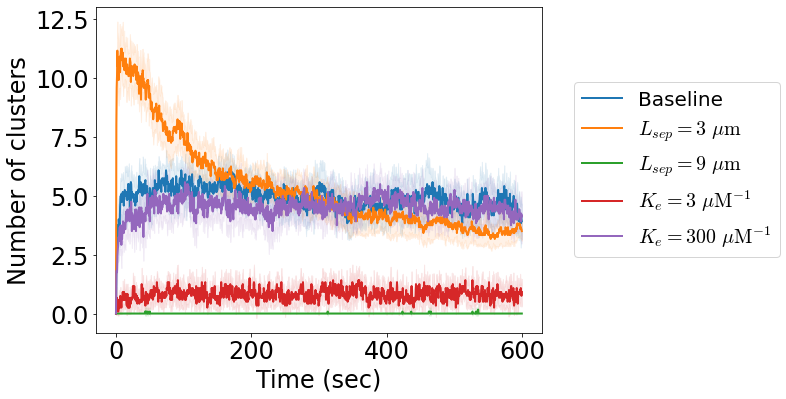

In [ ]:
# data_path_dict = {'Baseline': slice_path / "Ke30_Pin5.0um/", 
#                   r'$L_{sep} = 3~\mu {\rm m}$' :slice_path / "Ke30_Pin3.0um/",
#                   r'$L_{sep} = 9~\mu {\rm m}$' : slice_path / "Ke30_Pin9.0um/",
#                   r'$K_e = 3~\mu {\rm M}^{-1}$' : slice_path / "Ke3_Pin5.0um/",
#                   r'$K_e = 300~\mu {\rm M}^{-1}$' : slice_path / "Ke300_Pin5.0um/",
#                   }

labels_to_graph_dict = {'Baseline': "Pin5.0um_Ke30/", 
                  r'$L_{sep} = 3~\mu {\rm m}$' :"Pin3.0um_Ke30",
                  r'$L_{sep} = 9~\mu {\rm m}$' : "Pin9.0um_Ke30",
                  r'$K_e = 3~\mu {\rm M}^{-1}$' : "Pin5.0um_Ke3/",
                  r'$K_e = 300~\mu {\rm M}^{-1}$' : "Pin5.0um_Ke300",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for label, key in labels_to_graph_dict.items():
        h5_data = h5d[key]
        mean = h5_data[:, 2]
        std_dev = h5_data[:, 3]
        # num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr, mean, std_dev, 12, color=next(tableau10_cycler)['color'], label=label)

    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Time (sec)')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

